In [1]:
import numpy as np
import os
from PIL import Image

from scipy.ndimage import shift
from skimage import io

import matplotlib.pyplot as plt
%matplotlib inline

import ipywidgets as widgets
from ipywidgets import interactive


In [2]:
image1 = os.path.join("data",  "siemens_star.tif")
assert os.path.exists(image1), f"File does not exist: {image1}"

# Load images
data_images1 = np.array(Image.open(image1))

In [14]:
shift_config = {'chip1': {'xoffset': 2.4,
                    'yoffset': 1,
                    'description': 'top right chip'},
            'chip2': {'xoffset': 0,
                    'yoffset': 0,
                    'description': 'top left and reference chip'},
            'chip3': {'xoffset': 0,
                        'yoffset': 1,
                        'description': 'bottom left chip'},
            'chip4': {'xoffset': 2.3,
                    'yoffset': 2.3,
                    'description': 'bottom right chip'}
}
config = shift_config

chip_size = (256, 256)


# Applying shift correction based on the configuration

In [55]:
# max_xoffset = int(np.ceil(np.max([shift_config['chip1']['xoffset'],
#                       shift_config['chip4']['xoffset']])))
# max_yoffset = int(np.ceil(np.max([shift_config['chip3']['yoffset'],
#                       shift_config['chip4']['yoffset']])))

def apply_shift_correction(image, shift_config):

    image[np.isnan(image)] = 0
    image[np.isinf(image)] = 0

    # create an empty array for new image
    # new_image = np.zeros_like(image)
    new_image = np.zeros((image.shape[0], image.shape[1]))

    # chip 2 (fixed one)
    new_image[0:256, 0:256] = image[0:256, 0:256]

    # chip 1
    region = image[0:256, 256:]
    chips1_shift = (shift_config['chip1']['yoffset'], shift_config['chip1']['xoffset'])
    shifted_data = shift(region, shift=chips1_shift, order=3)
    new_image[0:256, 256:] = shifted_data

    # chip 3
    region = image[256:, 0:256]
    chips3_shift = (shift_config['chip3']['yoffset'], shift_config['chip3']['xoffset'])
    shifted_data = shift(region, shift=chips3_shift, order=3)
    new_image[256:, 0:256] = shifted_data

    # chip 4
    region = image[256:, 256:]
    chips4_shift = (shift_config['chip4']['yoffset'], shift_config['chip4']['xoffset'])
    shifted_data = shift(region, shift=chips4_shift, order=3)
    new_image[256:, 256:] = shifted_data

    return new_image

Text(0.5, 1.0, 'Corrected Image')

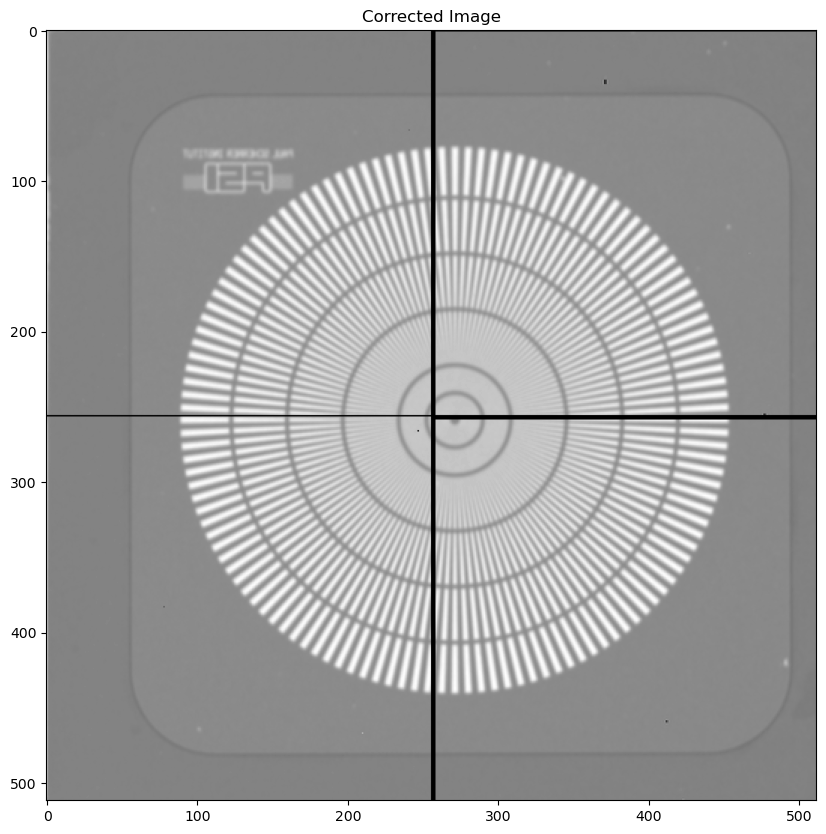

In [56]:
new_image = apply_shift_correction(data_images1, shift_config)
untouched_image = new_image.copy()

fig, axs = plt.subplots(ncols=1, figsize=(10, 10))
axs.imshow(new_image, cmap='gray')
axs.set_title("Corrected Image")

In [6]:

zoom_size = 15
region_zoomed = [100, 110, 245, 260]

def plot_zoomed(y=100, x=100):

    fig, axs = plt.subplots(ncols=2, figsize=(15, 10))
    axs[0].imshow(new_image[y: y+zoom_size, x: x+zoom_size])
    # show grid
    axs[0].grid(True)

    axs[1].imshow(new_image)
    # display the zoomed region
    rectangle = plt.Rectangle((x, y), zoom_size, zoom_size, edgecolor='red', facecolor='none')
    axs[1].add_patch(rectangle)
    plt.show()

display_zoom = interactive(plot_zoomed, y=widgets.IntSlider(min=0, max=512-zoom_size, step=1, value=region_zoomed[0]),
                                       x=widgets.IntSlider(min=0, max=512-zoom_size, step=1, value=region_zoomed[2]))
display(display_zoom)


interactive(children=(IntSlider(value=100, description='y', max=497), IntSlider(value=245, description='x', ma…

## Performing the interpolation of the gaps, one gap at a time

### between chips 1 and 2 (vertical gap)

In [18]:
# between chips 1 and 2 (vertical gap)
# gap is config['chip1']['xoffset'] (horizontal) and config['chip1']['yoffset'] (vertical)
# y will go from 0 to chip_size[0] + config['chip1']['yoffset']
new_image_corrected = new_image.copy()

for _y in range(0, chip_size[0] + int(np.ceil(shift_config['chip1']['yoffset']))):
    left_value = new_image_corrected[_y, chip_size[0]-1]
    right_value = new_image_corrected[_y, chip_size[0] + int(np.ceil(shift_config['chip1']['xoffset']))]

    if left_value == 0 and right_value == 0:
        list_new_value = np.zeros(int(np.ceil(shift_config['chip1']['xoffset'])))
    if left_value == 0:
        list_new_value = np.ones(int(np.ceil(shift_config['chip1']['xoffset']))) * right_value
    elif right_value == 0:
        list_new_value = np.ones(int(np.ceil(shift_config['chip1']['xoffset']))) * left_value
    else:
        list_new_value = np.interp(np.arange(1, int(np.ceil(shift_config['chip1']['xoffset'])) + 1), [0, int(np.ceil(shift_config['chip1']['xoffset'])) + 1], [left_value, right_value])

    new_image[_y, chip_size[1]:chip_size[1]+ int(np.ceil(shift_config['chip1']['xoffset']))] = list_new_value


In [17]:

zoom_size = 15
region_zoomed = [100, 245] # y0, x0
 
def plot_zoomed(y=100, x=100):

    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
    im0 = axs[0, 0].imshow(new_image[y: y+zoom_size, x: x+zoom_size], vmin=0.55, vmax=0.95)
    # show grid
    axs[0, 0].grid(True)
    plt.colorbar(im0, ax=axs[0, 0], shrink=0.8)
    axs[0, 0].set_title("Corrected Image")

    axs[0, 1].imshow(new_image)
    # display the zoomed region
    rectangle = plt.Rectangle((x, y), zoom_size, zoom_size, edgecolor='red', facecolor='none')
    axs[0, 1].add_patch(rectangle)


    im1 = axs[1, 0].imshow(untouched_image[y: y+zoom_size, x: x+zoom_size], vmin=0.55, vmax=0.95)
    # show grid
    axs[1, 0].grid(True)
    plt.colorbar(im1, ax=axs[1, 0], shrink=0.8)
    axs[1, 0].set_title("Original Image")

    axs[1, 1].imshow(untouched_image)
    # display the zoomed region
    rectangle = plt.Rectangle((x, y), zoom_size, zoom_size, edgecolor='red', facecolor='none')
    axs[1, 1].add_patch(rectangle)

    plt.show()

display_zoom = interactive(plot_zoomed, y=widgets.IntSlider(min=0, max=512-zoom_size, step=1, value=region_zoomed[0]),
                                       x=widgets.IntSlider(min=0, max=512-zoom_size, step=1, value=region_zoomed[1]))
display(display_zoom)

interactive(children=(IntSlider(value=100, description='y', max=497), IntSlider(value=245, description='x', ma…

### between chips 1 and 3 (horizontal gap)

In [19]:
# between chips 2 and 3
# gap is config['chip3']['xoffset'] (horizontal) and config['chip3']['yoffset'] (vertical)
# x will go from 0 to chip_size[1] + config['chip3']['xoffset']

for _x in range(0, chip_size[1] + config['chip3']['xoffset']):
    left_value = new_image_corrected[chip_size[0]-1, _x]
    right_value = new_image_corrected[chip_size[0] + config['chip3']['yoffset'], _x]
    if left_value == 0 and right_value == 0:
        list_new_value = np.zeros(config['chip3']['yoffset'])
    if left_value == 0:
        list_new_value = np.ones(config['chip3']['yoffset']) * right_value
    elif right_value == 0:
        list_new_value = np.ones(config['chip3']['yoffset']) * left_value
    else:
        list_new_value = np.interp(np.arange(1, config['chip3']['yoffset'] + 1), [0, config['chip3']['yoffset'] + 1], [left_value, right_value])

    new_image_corrected[chip_size[0]:chip_size[0]+config['chip3']['yoffset'], _x] = list_new_value

In [25]:

zoom_size = 15
region_zoomed = [248, 144] # y0, x0

def plot_zoomed(y=0, x=248):

    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
    im0 = axs[0, 0].imshow(new_image_corrected[y: y+zoom_size, x: x+zoom_size], vmin=0.55, vmax=0.95)
    # show grid
    axs[0, 0].grid(True)
    plt.colorbar(im0, ax=axs[0, 0], shrink=0.8)
    axs[0, 0].set_title("Corrected Image")

    axs[0, 1].imshow(new_image_corrected)
    # display the zoomed region
    rectangle = plt.Rectangle((x, y), zoom_size, zoom_size, edgecolor='red', facecolor='none')
    axs[0, 1].add_patch(rectangle)


    im1 = axs[1, 0].imshow(untouched_image[y: y+zoom_size, x: x+zoom_size], vmin=0.55, vmax=0.95)
    # show grid
    axs[1, 0].grid(True)
    plt.colorbar(im1, ax=axs[1, 0], shrink=0.8)
    axs[1, 0].set_title("Original Image")

    axs[1, 1].imshow(untouched_image)
    # display the zoomed region
    rectangle = plt.Rectangle((x, y), zoom_size, zoom_size, edgecolor='red', facecolor='none')
    axs[1, 1].add_patch(rectangle)

    plt.show()

display_zoom = interactive(plot_zoomed, y=widgets.IntSlider(min=0, max=512-zoom_size, step=1, value=region_zoomed[0]),
                                       x=widgets.IntSlider(min=0, max=512-zoom_size, step=1, value=region_zoomed[1]))
display(display_zoom)

interactive(children=(IntSlider(value=248, description='y', max=497), IntSlider(value=144, description='x', ma…

# between chips 3 and 4 (vertical gap)

In [31]:
np.ceil(config['chip4']['xoffset'])

np.float64(3.0)

In [59]:
for _y in range(chip_size[0] + np.ceil(config['chip3']['yoffset']) + config['chip1']['yoffset'], 2*chip_size[0] + np.ceil(config['chip3']['yoffset']) + config['chip1']['yoffset']-2):
    left_value = new_image_corrected[_y, chip_size[1]-1]
    right_value = new_image_corrected[_y, chip_size[1] + int(np.ceil(config['chip4']['xoffset']))]
    if left_value == 0 and right_value == 0:
        list_new_value = np.zeros(config['chip4']['xoffset'])
    if left_value == 0:
        list_new_value = np.ones(int(np.ceil(config['chip4']['xoffset']))) * right_value
    elif right_value == 0:
        list_new_value = np.ones(int(np.ceil(config['chip4']['xoffset']))) * left_value
    else:
        list_new_value = np.interp(np.arange(1, int(np.ceil(config['chip4']['xoffset'])) + 1), [0, int(np.ceil(config['chip4']['xoffset'])) + 1], [left_value, right_value])

    new_image_corrected[_y, chip_size[1]:chip_size[1]+int(np.ceil(config['chip4']['xoffset']))] = list_new_value

In [61]:
zoom_size = 15
region_zoomed = [376, 248] # y0, x0

def plot_zoomed(y=0, x=248):

    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
    im0 = axs[0, 0].imshow(new_image_corrected[y: y+zoom_size, x: x+zoom_size], vmin=0.55, vmax=0.95)
    # show grid
    axs[0, 0].grid(True)
    plt.colorbar(im0, ax=axs[0, 0], shrink=0.8)
    axs[0, 0].set_title("Corrected Image")

    axs[0, 1].imshow(new_image_corrected)
    # display the zoomed region
    rectangle = plt.Rectangle((x, y), zoom_size, zoom_size, edgecolor='red', facecolor='none')
    axs[0, 1].add_patch(rectangle)


    im1 = axs[1, 0].imshow(untouched_image[y: y+zoom_size, x: x+zoom_size], vmin=0.55, vmax=0.95)
    # show grid
    axs[1, 0].grid(True)
    plt.colorbar(im1, ax=axs[1, 0], shrink=0.8)
    axs[1, 0].set_title("Original Image")

    axs[1, 1].imshow(untouched_image)
    # display the zoomed region
    rectangle = plt.Rectangle((x, y), zoom_size, zoom_size, edgecolor='red', facecolor='none')
    axs[1, 1].add_patch(rectangle)

    plt.show()

display_zoom = interactive(plot_zoomed, y=widgets.IntSlider(min=0, max=512-zoom_size, step=1, value=region_zoomed[0]),
                                       x=widgets.IntSlider(min=0, max=512-zoom_size, step=1, value=region_zoomed[1]))
display(display_zoom)

interactive(children=(IntSlider(value=376, description='y', max=497), IntSlider(value=248, description='x', ma…

# between chips 1 and 4 (horizontal gap)

In [ ]:
# between chips 1 and 4
# gap is config['chip4']['xoffset'] - config['chip1']['xoffset'] (horizontal) and config['chip4']['yoffset'] - config['chip1']['yoffset'] (vertical)
# x will go from chip_size[1]+config['chip1']['xoffset'] to 2*chip_size[1]+config['chip1']['xoffset']

for _x in range(chip_size[1] + int(np.ceil(config['chip1']['xoffset'])), 2*chip_size[1] + int(np.ceil(config['chip1']['xoffset']))-3):
    left_value = new_image_corrected[chip_size[0]-1 + config['chip1']['yoffset'], _x]
    # print(f"y_left: {chip_size[0]-1 + config['chip1']['yoffset']}", end=", ")
    # print(f"y_right: {chip_size[0] + config['chip4']['yoffset']}")
    right_value = new_image_corrected[chip_size[0] + int(np.ceil(config['chip4']['yoffset'])), _x]
    if left_value == 0 and right_value == 0:
        list_new_value = np.zeros(int(np.ceil(config['chip4']['yoffset'])))
    if left_value == 0:
        list_new_value = np.ones(int(np.ceil(config['chip4']['yoffset']))) * right_value
    elif right_value == 0:
        list_new_value = np.ones(int(np.ceil(config['chip4']['yoffset']))) * left_value
    else:
        list_new_value = np.interp(np.arange(1, int(np.ceil(config['chip4']['yoffset']))), 
                                   [0, int(np.ceil(config['chip4']['yoffset'])) + int(np.ceil(config['chip1']['yoffset']))-1], 
                                   [left_value, right_value])

    new_image_corrected[chip_size[0] + int(np.ceil(config['chip1']['yoffset'])):chip_size[0]+int(np.ceil(config['chip4']['yoffset']))+
                     int(np.ceil(config['chip1']['yoffset'])), _x] = list_new_value

259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
